Epoch 1, Training Loss: 0.0164, Validation Loss: 0.0089
Epoch 2, Training Loss: 0.0082, Validation Loss: 0.0092
Epoch 3, Training Loss: 0.0082, Validation Loss: 0.0080
Epoch 4, Training Loss: 0.0080, Validation Loss: 0.0090
Epoch 5, Training Loss: 0.0080, Validation Loss: 0.0081
Epoch 6, Training Loss: 0.0080, Validation Loss: 0.0084
Epoch 7, Training Loss: 0.0080, Validation Loss: 0.0081
Epoch 8, Training Loss: 0.0079, Validation Loss: 0.0082
Epoch 9, Training Loss: 0.0079, Validation Loss: 0.0082
Epoch 10, Training Loss: 0.0078, Validation Loss: 0.0087
Epoch 11, Training Loss: 0.0079, Validation Loss: 0.0085
Epoch 12, Training Loss: 0.0079, Validation Loss: 0.0082
Epoch 13, Training Loss: 0.0078, Validation Loss: 0.0081
Early stopping
Mean Absolute Error: 7.890189170837402


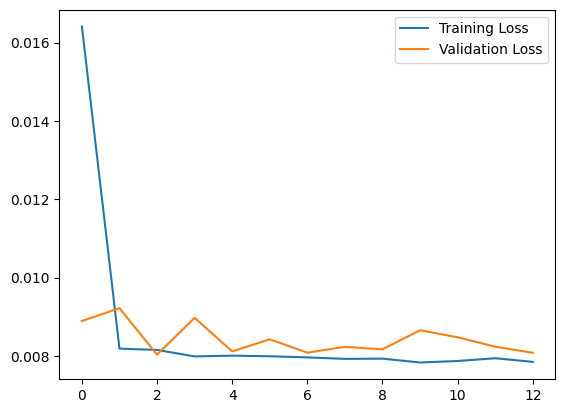

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Verificar se CUDA está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar os dados
data = pd.read_csv('./dados_tratados/combinado/Piratininga/Piratininga_tratado_combinado.csv', usecols=['PM2.5'])

data = data.dropna()

# Supondo que os dados estão em uma coluna chamada 'PM2.5'
values = data['PM2.5'].values

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values)

# Função para criar sequências de dados
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 8
X, y = create_sequences(scaled_values, seq_length)

# Divisão dos dados em treino, temporário para teste e validação
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Divisão dos dados temporários em teste e validação
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Conversão para tensores do PyTorch
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Criação de DataLoader
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.gru = nn.GRU(input_size, hidden_layer_size, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        gru_out, _ = self.gru(input_seq)
        gru_out = gru_out[:, -1, :]
        predictions = self.linear(gru_out)
        return predictions

# Instanciando o modelo, a função de perda e o otimizador
model = GRUModel().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento
def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=150, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)  # Mover para GPU
            optimizer.zero_grad()
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * seq.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)  # Mover para GPU
                y_pred = model(seq)
                loss = loss_function(y_pred, labels)
                val_loss += loss.item() * seq.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

    return train_losses, val_losses

# Treinamento do modelo
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_function, optimizer)

# Carregar o melhor modelo
model.load_state_dict(torch.load('best_model.pth'))

# Avaliação do modelo
model.eval()
test_predictions = []

with torch.no_grad():
    for seq, labels in test_loader:
        seq, labels = seq.to(device), labels.to(device)  # Mover para GPU
        y_pred = model(seq)
        test_predictions.append(y_pred.cpu().numpy())  # Mover para CPU antes de adicionar

test_predictions = np.concatenate(test_predictions, axis=0)

# Desnormalização das previsões
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

# Calculando o erro médio absoluto (MAE)
mae = np.mean(np.abs(test_predictions - y_test))
mse = np.mean((test_predictions - y_test) ** 2)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Plotagem das perdas de treinamento e validação
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()
